# *1. Загрузка библиотек и оптимизация графического процессора*

In [ ]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import cv2
from tensorflow.keras.metrics import CategoricalAccuracy

In [ ]:
# для управления использованием памяти на GPU в TensorFlow
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    #функция, которая устанавливает режим динамического выделения памяти для каждого устройства GPU
    tf.config.experimental.set_memory_growth(gpu, True)

# *2. Подготовка данных*

In [ ]:
drive.mount('/content/drive')

NameError: ignored

In [ ]:
# папка с данными
data_dir = '/content/drive/MyDrive/data_project'

In [ ]:
# нужные разрешения данных
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
# Перебираем все файлы в директории data_dir, включая файлы в подпапках, root директории, dirs список всех подиректориев, список файлов в files
for root, dirs, files in os.walk(data_dir):
    # Перебираем все файлы в текущей директории
    for file in files:
        # Полный путь к файлу
        file_path = os.path.join(root, file)
        try:
            # Проверяем, является ли файл изображением
            if imghdr.what(file_path) not in image_exts:
                # Если файл не является изображением, удаляем его и выводим сообщение
                print(f'Удалено: {file_path}')
                os.remove(file_path)
        except Exception as e:
            # Если при обработке файла возникла ошибка, выводим сообщение об ошибке
            print(f'Ошибка {file_path}: {str(e)}')

# *3.Загрузка данных*

In [ ]:
# автоматически собирает изображения из папок в указанной директории и создает датасет, разделяя их на классы
# привели все изображение в формат 256 на 256 пикселей и поделили в пакеты по 32 штуки
data = tf.keras.utils.image_dataset_from_directory(data_dir,label_mode = 'categorical')

Found 492 files belonging to 4 classes.


In [ ]:
num_classes = 4

In [ ]:
# позволяет извлекать пакеты изображений и меток из этого объекта, преобразуя их в numpy-массивы
data_iterator = data.as_numpy_iterator()

In [ ]:
# используется для получения следующего набора данных
# batch[0] хранит в себе данные о изображении, batch[1] метки классов
batch = data_iterator.next()

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


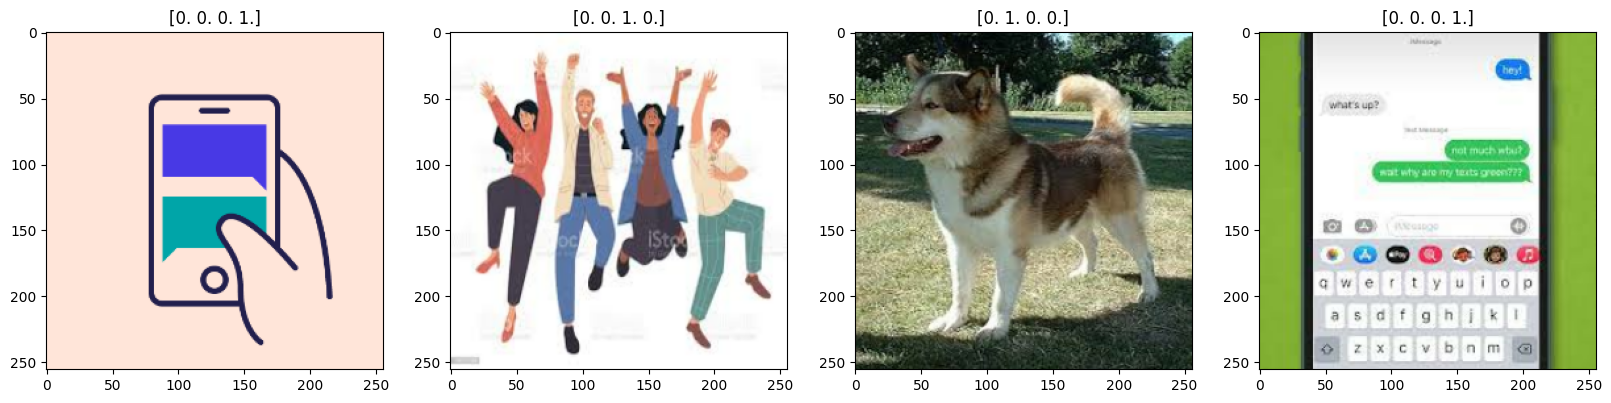

In [ ]:
# посмотрим данные, чтобы понять каким классам присвоены какие индексы
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# *4.Масштабирование данных*

In [ ]:
# для упрощения обучения моделей машинного обучения отмасштабируем данные в диапазоне от 0 до 1
# 0 соответствует черному цвету или минимальной яркости, а 255 соответствует белому цвету или максимальной яркости.
data = data.map(lambda x,y: (x/255, y))

In [ ]:
data.as_numpy_iterator().next()

(array([[[[9.29411769e-01, 9.29411769e-01, 9.29411769e-01],
          [9.29411769e-01, 9.29411769e-01, 9.29411769e-01],
          [9.29411769e-01, 9.29411769e-01, 9.29411769e-01],
          ...,
          [1.00000000e+00, 9.86182570e-01, 1.00000000e+00],
          [1.00000000e+00, 9.84650731e-01, 1.00000000e+00],
          [1.00000000e+00, 9.84313726e-01, 1.00000000e+00]],
 
         [[9.34466898e-01, 9.34466898e-01, 9.34466898e-01],
          [9.34466898e-01, 9.34466898e-01, 9.34466898e-01],
          [9.34466898e-01, 9.34466898e-01, 9.34466898e-01],
          ...,
          [9.97785747e-01, 9.86680210e-01, 1.00000000e+00],
          [9.97390807e-01, 9.85016704e-01, 1.00000000e+00],
          [9.97303903e-01, 9.84650731e-01, 1.00000000e+00]],
 
         [[9.57444847e-01, 9.57444847e-01, 9.57444847e-01],
          [9.57444847e-01, 9.57444847e-01, 9.57444847e-01],
          [9.57444847e-01, 9.57444847e-01, 9.57444847e-01],
          ...,
          [9.87720907e-01, 9.88942087e-01, 1.0000

# *5.Разделение данных*

In [ ]:
# количество пакетов
len(data)

16

In [ ]:
# расставляем пропорции разделени данных
train_size = int(len(data)*.7)
val_size = int(len(data)*.3)
test_size = int(len(data)*.1+1)

In [ ]:
# пропускаем некоторые пакет, чтобы одни данные не лежали в нескольких выборках
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# *6.Модель глубокого обучения*

In [ ]:
# проверим что наши данные имею размер 256 на 256 пикселей и три канала цвета
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
# создание модели
model = Sequential()

In [ ]:
# Добавление слоя свертки (Conv2D) с 16 фильтрами, размером ядра 3х3, шагом 1 и функцией активации 'relu'.
# relu устанавливает выходное значение равным нулю, в противном случае выходное значение равно входному сигналу. Является нелинейной и способна устранить проблему затухания
# Первый слой является входным, и имеет размерность (256,256,3), где 3 соответствует количеству цветовых каналов (RGB).
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# Добавление слоя подвыборки (MaxPooling2D) для уменьшения размера выходных данных от предыдущего слоя свертки в два раза.
# Слой MaxPooling2D выбирает максимальное значение из окна
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
# этоn слой нейронной сети, который используется для преобразования многомерного входного тензора в одномерный тензор.
model.add(Flatten())
# этот слой используется для извлечения признаков из выходных данных Flatten() слоя.
model.add(Dense(256, activation='relu'))
# softmax используется для вычисления вероятностей каждого класса для данного входа.
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# задает параметры компиляции модели, где 'adam' - это алгоритм оптимизации,  loss='categorical_crossentropy' - Функция потерь 'categorical_crossentropy' вычисляет расстояние между этим истинным вектором и предсказанным вектором вероятностей.

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# выводит сводку информации о модели, такую как общее количество параметров, размерность каждого слоя и количество выводов.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

#*7.Обучение*

In [ ]:
# пределяем директорию для сохранения логов для TensorBoard
logdir='logs'

In [ ]:
# Каждый раз, когда происходит обучение, TensorBoard сохраняет информацию о ходе обучения и результаты метрик
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# обучаем модель на тренировочных данных train с 20 эпохами и указываем данные валидации val. Кроме того, мы передаем tensorboard_callback в аргументе обратного вызова, чтобы сохранять логи в TensorBoard.
hist = model.fit(train,batch_size=32, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
11/11 [==============================] - 22s 890ms/step - loss: 1.3316 - accuracy: 0.4006 - val_loss: 1.0995 - val_accuracy: 0.5703
Epoch 2/20
11/11 [==============================] - 16s 1s/step - loss: 1.0228 - accuracy: 0.5625 - val_loss: 1.0801 - val_accuracy: 0.5547
Epoch 3/20
11/11 [==============================] - 11s 892ms/step - loss: 0.8100 - accuracy: 0.6506 - val_loss: 0.7138 - val_accuracy: 0.6875
Epoch 4/20
11/11 [==============================] - 10s 760ms/step - loss: 0.6846 - accuracy: 0.7528 - val_loss: 0.6587 - val_accuracy: 0.7734
Epoch 5/20
11/11 [==============================] - 11s 782ms/step - loss: 0.6189 - accuracy: 0.7841 - val_loss: 0.3688 - val_accuracy: 0.9062
Epoch 6/20
11/11 [==============================] - 11s 888ms/step - loss: 0.4336 - accuracy: 0.8636 - val_loss: 0.3329 - val_accuracy: 0.8984
Epoch 7/20
11/11 [==============================] - 10s 767ms/step - loss: 0.3037 - accuracy: 0.9318 - val_loss: 0.1730 - val_accuracy: 0.9688
Ep

#*8.Визуализация метрик*

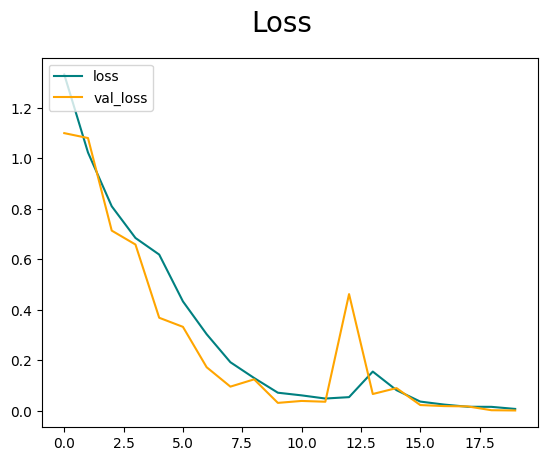

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

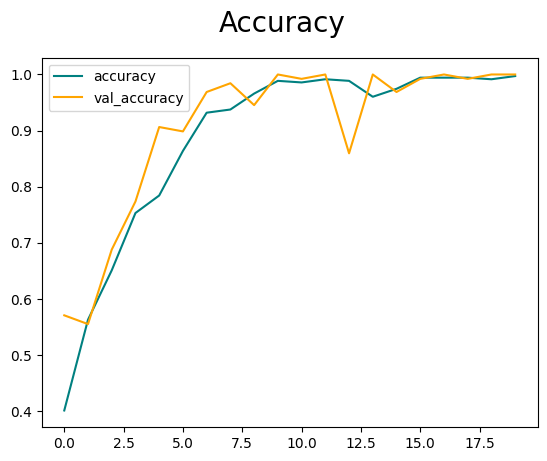

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#*9.Оценка качества модели*

In [ ]:
#точность
pre = Precision()
#полнота
re = Recall()
#множественная метрика точности
acc = CategoricalAccuracy()

In [ ]:
#тестовым данным test и делаем предсказания на каждом батче данных X с помощью model.predict(X). Затем, мы обновляем значения метрик pre, re и acc
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)


1/1 [==============================] - 0s 363ms/step


In [ ]:
#точность, полнота и множественная точность высоки, значит модель показывает хорошие результаты
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


#*10.Проверка*

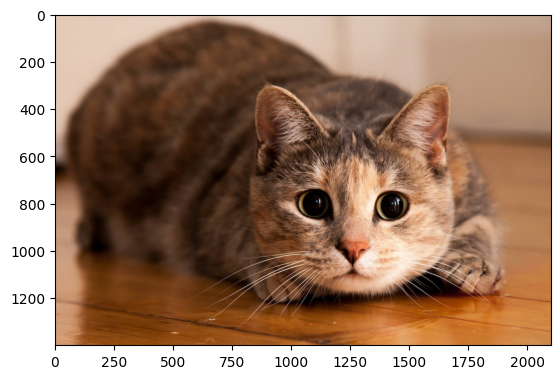

In [ ]:
img = cv2.imread('/content/drive/MyDrive/42a857cdb7986b8ff7f46d8c7b20cedf.jpeg')
# меняем цвета BGR на RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

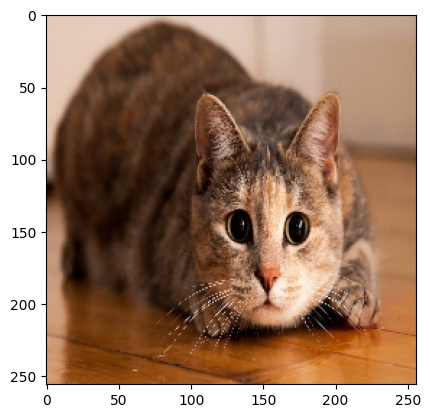

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 132ms/step


In [ ]:
yhat

array([[9.5865303e-01, 4.1126199e-02, 1.8719192e-04, 3.3639400e-05]],
      dtype=float32)

In [ ]:
# проверяем, больше ли вероятность, что изображение принадлежит каждому из четырех классов, порогового значения 0,5.
if yhat[0][0] > 0.5:
    print('Кошки')
elif yhat[0][1] > 0.5:
    print('Собаки')
elif yhat[0][2] > 0.5:
    print('Люди')
else:
    print('Текст')

Кошки


#*11.Сохранение модели*

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier_bonus_track.h5'))

#*12.Пользовательская загрузка данных для структуризации фото*

In [ ]:
import shutil
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files

In [ ]:
# Загрузка обученной модели
model = load_model('models/imageclassifier_bonus_track.h5')

In [ ]:
# Список классов
classes = ['Кошки', 'Собаки', 'Люди', 'Текст']

In [ ]:
# Выбор файла для загрузки
uploaded = files.upload()

Saving 42a857cdb7986b8ff7f46d8c7b20cedf.jpeg to 42a857cdb7986b8ff7f46d8c7b20cedf.jpeg
Saving image007.png to image007.png
Saving telephone-Person-beard-professional-conversation-businessman-business-executive-619479.jpg to telephone-Person-beard-professional-conversation-businessman-business-executive-619479.jpg
Saving Zk694hbA4tSKF3rKbHARsXJSI1dds9vJkNXiCdCPvFh9VuzKI1lXmKjnAdSqCxm_y5zCg3u4.jpg to Zk694hbA4tSKF3rKbHARsXJSI1dds9vJkNXiCdCPvFh9VuzKI1lXmKjnAdSqCxm_y5zCg3u4.jpg


In [ ]:
# Получение списка путей к выбранным файлам
input_folder = 'input_folder'
if not os.path.exists(input_folder):
    os.makedirs(input_folder)

for filename in uploaded.keys():
    with open(os.path.join(input_folder, filename), 'wb') as f:
        f.write(uploaded[filename])

In [ ]:
# Путь к папке для сохранения классифицированных фотографий
output_folder = 'Фото пользователя'

In [ ]:
# Создание папок для классов
for class_name in classes:
    class_folder = os.path.join(output_folder, class_name)
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)

In [ ]:
# Классификация фотографий и копирование их в соответствующие папки
for filename in os.listdir(input_folder):
    filepath = os.path.join(input_folder, filename)
    try:
        image = load_img(filepath, target_size=(256, 256))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image /= 255.0
        prediction = model.predict(image)
        predicted_class = classes[np.argmax(prediction)]
        shutil.copy(filepath, os.path.join(output_folder, predicted_class, filename))
    except:
        print(f"It was not possible to classify the photos, we will add to the database soon, thank you) {filepath}")

1/1 [==============================] - 0s 25ms/step
